In [1]:
import os
import torch
import numpy as np
import random
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.signal import welch
import os, warnings, pickle
from torch.autograd import Variable
from torch.utils.data import DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler


### Predefined params and utils

In [6]:
# Define channels used
select_channels = ['ch1_LF5 - FpZ', 'ch2_OTE_L-FpZ', 'ch4_RF6-FpZ', 'ch5_OTE_R-FpZ']

# Define frequency bands
bands = {'Delta band':[0.5, 4], 'Alpha band': [8, 12],
         'Beta band':[13, 30], 'Gamma band':[30, 100]}
'''
bands = {'Band {}'.format(i): [0.5 + i*2.0, 0.5 + (i + 1)*2.0] for i in range(10)}
bands.update({'Band {}'.format(10 + i): [20.5 + i*10, 20.5 + (i + 1)*10] for i in range(5)})
bands.update({'Band 15': [70.5, 100.0]})
'''

# Define sampling frequency
sampling_rate = 125

# Get all data from folder
folder = '/data1/Test'
ex_files = []
'''
ex_files = ['Copy of eeg_focus_6sessions_cut_S2.csv', 
            'Copy of eeg_focus_6sessions_cut_S4.csv', 
            'Copy of eeg_focus_6sessions_cut_S7.csv',
           'Copy of eeg_focus_6sessions_cut_S8.csv']
'''
files = [f for f in os.listdir(folder) if f.endswith('.csv') and not f.endswith('.processed.csv') and f not in ex_files]

# define data loader
def load_data(data_path, window_size_in_seconds=24, data_n=10000, 
              time_domain_feature_num=128, 
              average_channels=False
             ):
  df = pd.read_csv(data_path)[select_channels]
  # Define time vector
  time = np.arange(len(df)) / sampling_rate
  # Create DataFrame to store output
  final_df = pd.DataFrame()
  for channel in tqdm(range(len(select_channels)), desc='Processing'):
      temp_df = df[select_channels[channel]].values
      # Initialize arrays to store power in each band over time
      power = np.zeros((df.shape[0], len(bands)))
      for i in range(len(temp_df)):
          frequencies, psd = welch(temp_df[:i+1], fs=sampling_rate, nperseg=min(1024, i+1))
          for idx, (_, item) in enumerate(bands.items()):
              power[i, idx] = np.trapz(psd[(frequencies >= item[0]) & (frequencies <= item[1])], frequencies[(frequencies >= item[0]) & (frequencies <= item[1])])
      # Concat output
      final_df = pd.concat([final_df, pd.DataFrame(power, columns=bands.keys())], axis=1)
  df_scaled = (final_df - final_df.min()) / (final_df.max() - final_df.min())
  # Calculate average values for each banch
  if average_channels:
      df_new = pd.DataFrame()
      for key in bands.keys():
          df_temp = df_scaled[key].mean(axis=1, skipna=False)
          df_new[key] = df_temp
  else:
      df_new = df_scaled

  # Create y vector with empty values
  y = np.empty(shape=len(df_new))
  y[:] = np.nan

  # Assign output values represent for eyes closed duration (0) and immersion duration (1)
  num_elements, step = data_n, int(len(df_new)/11)
  step_1, step_2, step_3 = 2*step, 4*step, 6*step

  # Generate random indices within the specified range
  random_indices = np.random.choice(np.arange(0, step_1), num_elements, replace=True)
  y[random_indices] = 0.0
  random_indices = np.random.choice(np.arange(step_1, step_2), num_elements, replace=True)
  y[random_indices] = 0.25
  random_indices = np.random.choice(np.arange(step_2, step_3), num_elements, replace=True)
  y[random_indices] = 0.75
  random_indices = np.random.choice(np.arange(step_3, 11*step), num_elements, replace=True)
  y[random_indices] = 1.0

  # Assign y value vector original data
  df_new['y'] = y

  # add padding
  if window_size_in_seconds > 0:
      window_size = window_size_in_seconds*sampling_rate # seconds
      padding = pd.DataFrame(np.zeros((window_size, df_new.shape[1])), columns=df_new.columns)
      padding['y'] = np.NaN
      df_new_padding = pd.concat([padding, df_new])
      # X = np.array(df_new_padding.drop(columns=['y']))
      X = df_new_padding.drop(columns=['y'])
      y = np.array(df_new_padding['y'])
      X_new_cols = X.shape[1]*time_domain_feature_num
      X_new = []
      for i in range(padding.shape[0], X.shape[0]):
        _x = X[i - padding.shape[0] : i].sample(n=time_domain_feature_num, random_state=1)
        if average_channels:
            _x = np.array(_x).reshape(1, X_new_cols).tolist()[0]
        else:
            _x = _x.values
            _x1 = []
            for c in range(len(select_channels)):
                _xc = _x[:, c:c + len(bands)].reshape(1, time_domain_feature_num*len(bands)).tolist()[0]
                _x1.append(_xc)
            _x = np.concatenate(_x1)
        X_new.append(_x)
      #X_new = np.array(X_new)
      df_new = pd.DataFrame(X_new)
      df_new['y'] = y[window_size:]
  return df_new, df_scaled

def create_datasets(window_size_in_seconds):
    processed_data_files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(f'padding_{window_size_in_seconds}s.processed.csv') and f not in ex_files]
    for f in processed_data_files:
        print(f)

# Predict
def predict_dataset(loaded_model, data_f):
    df_new = pd.read_csv(open(data_f))
    scaler = StandardScaler()
    y_pred = loaded_model.predict_proba(scaler.transform(np.array(df_new.drop(columns=['y']))))[:,1]
    
    # Scale between 0 and 100
    xmax = 100
    min_val, max_val = np.min(y_pred), np.max(y_pred)
    scaled_arr = xmax * (y_pred - min_val) / (max_val - min_val)\
    
    time = np.arange(len(df_new)) / sampling_rate
    # Plot
    plt.figure(figsize=(15, 6))
    plt.plot(time, scaled_arr, label='Focus Level')
    plt.title(f'{data_f}')
    plt.xlabel('Time (s)')
    plt.ylabel('Focus Score')
    plt.grid(True)
    plt.show()

### Process raw data and extract features

In [44]:
# Read all files in folder and do feature extraction
print(bands)
window_size_in_seconds = 24
files = [f for f in os.listdir(folder) if f.endswith('.csv') and not f.endswith('.processed.csv') and f not in ex_files]
# files = ['Copy of eeg_focus_6sessions_cut_S1.csv']
print(files)
for file in files:
    path_ = os.path.join(folder, file)
    print(path_)
    df_new, df_scaled = load_data(path_, window_size_in_seconds)
    # save_data
    out_f = os.path.join(folder, file.rpartition('.csv')[0] + f'.b{len(bands)}.padding_{window_size_in_seconds}s.processed.csv')
    df_new.to_csv(out_f, index=False, header=True)
    print(f'save data to: {out_f}')
print('Done!')
# Build datasets for training and testing models


{'Delta band': [0.5, 4], 'Alpha band': [8, 12], 'Beta band': [13, 30], 'Gamma band': [30, 100]}
['Copy of eeg_focus_6sessions_cut_S7.csv', 'Copy of eeg_focus_6sessions_cut_S8.csv', 'Copy of eeg_focus_6sessions_cut_S2.csv', 'Copy of eeg_focus_6sessions_cut_S4.csv', 'Copy of eeg_focus_6sessions_cut_S10.csv', 'Copy of eeg_focus_6sessions_cut_S13.csv', 'Copy of eeg_focus_6sessions_cut_S6.csv', 'Copy of eeg_focus_6sessions_cut_S9.csv', 'Copy of eeg_focus_6sessions_cut_S3.csv', 'Copy of eeg_focus_6sessions_cut_S1.csv']
Data/Copy of eeg_focus_6sessions_cut_S7.csv


Processing: 100%|██████████| 4/4 [05:51<00:00, 87.90s/it]


save data to: Data/Copy of eeg_focus_6sessions_cut_S7.b4.padding_24s.processed.csv
Data/Copy of eeg_focus_6sessions_cut_S8.csv


Processing: 100%|██████████| 4/4 [05:28<00:00, 82.09s/it]


save data to: Data/Copy of eeg_focus_6sessions_cut_S8.b4.padding_24s.processed.csv
Data/Copy of eeg_focus_6sessions_cut_S2.csv


Processing: 100%|██████████| 4/4 [05:55<00:00, 88.89s/it]


save data to: Data/Copy of eeg_focus_6sessions_cut_S2.b4.padding_24s.processed.csv
Data/Copy of eeg_focus_6sessions_cut_S4.csv


Processing: 100%|██████████| 4/4 [05:08<00:00, 77.15s/it]


save data to: Data/Copy of eeg_focus_6sessions_cut_S4.b4.padding_24s.processed.csv
Data/Copy of eeg_focus_6sessions_cut_S10.csv


Processing: 100%|██████████| 4/4 [04:32<00:00, 68.06s/it]


save data to: Data/Copy of eeg_focus_6sessions_cut_S10.b4.padding_24s.processed.csv
Data/Copy of eeg_focus_6sessions_cut_S13.csv


Processing: 100%|██████████| 4/4 [05:43<00:00, 85.94s/it]


save data to: Data/Copy of eeg_focus_6sessions_cut_S13.b4.padding_24s.processed.csv
Data/Copy of eeg_focus_6sessions_cut_S6.csv


Processing: 100%|██████████| 4/4 [05:53<00:00, 88.32s/it]


save data to: Data/Copy of eeg_focus_6sessions_cut_S6.b4.padding_24s.processed.csv
Data/Copy of eeg_focus_6sessions_cut_S9.csv


Processing: 100%|██████████| 4/4 [05:45<00:00, 86.50s/it]


save data to: Data/Copy of eeg_focus_6sessions_cut_S9.b4.padding_24s.processed.csv
Data/Copy of eeg_focus_6sessions_cut_S3.csv


Processing: 100%|██████████| 4/4 [05:02<00:00, 75.58s/it]


save data to: Data/Copy of eeg_focus_6sessions_cut_S3.b4.padding_24s.processed.csv
Data/Copy of eeg_focus_6sessions_cut_S1.csv


Processing: 100%|██████████| 4/4 [05:56<00:00, 89.18s/it]


save data to: Data/Copy of eeg_focus_6sessions_cut_S1.b4.padding_24s.processed.csv
Done!


In [41]:
df_scaled[['Delta band']][128: 256]

,Delta band,Delta band,Delta band,Delta band
128,0.115719,0.044710,0.322455,0.010220
129,0.118998,0.045310,0.323740,0.010324
130,0.121623,0.045852,0.324553,0.010364
131,0.123969,0.046428,0.325150,0.010461
132,0.126846,0.046977,0.325268,0.010578
...,...,...,...,...
251,0.214886,0.022523,0.103839,0.013879
252,0.215087,0.022519,0.105256,0.013913
253,0.215257,0.022514,0.106723,0.013946
254,0.215397,0.022508,0.108241,0.013979


In [42]:
df_new.drop(columns=['y']).values.reshape(-1, 4, 128, 4)[1, 0, :, 0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

### Train Baseline model

In [6]:
df_new = pd.read_csv(open('Data/Copy of eeg_focus_6sessions_cut_S1.b4.padding_0s.processed.csv'))
# Generate data for building model
# df_data = df_new[~df_new['y'].isnull()]
df_data = df_new[(~df_new['y'].isnull()) & ((df_new['y'] < 0.01) | (df_new['y'] > 0.99))]
df_data = df_data.astype({'y': int})
X = np.array(df_data.drop(columns=['y']))
y = np.array(df_data['y'])


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_train)

# Train a linear regression model
model = LogisticRegression(random_state=42)

model.fit(X_normalized, y_train)
# save model
pickle.dump(model, open('model.pkl', 'wb'))
# Evaluate the model
y_pred = model.predict_proba(scaler.transform(X_test))[:,1]
mse = mean_squared_error(y_true=y_test, y_pred=y_pred)
print("Mean Squared Error", mse)
# y_pred

Mean Squared Error 0.00023582171091159917


### Test on the train and test datasets

[]

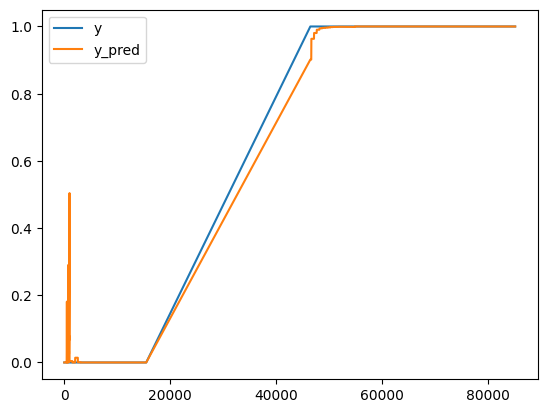

In [7]:
# Load the model from disk
loaded_model = pickle.load(open('/home/tungpd/Test/model.pkl', 'rb'))

# Predict
y_pred = loaded_model.predict_proba(scaler.transform(X))[:,1]
df_data.loc[:,'y_pred'] = y_pred
df_data[['y','y_pred']].plot()
plt.plot()

#### Test on entirely new datasets

In [9]:
processed_data_files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('padding_0s.processed.csv') and f not in ex_files]
for f in processed_data_files:
    print(f)
    predict_dataset(loaded_model, f)

Data/Copy of eeg_focus_6sessions_cut_S8.b4.padding_0s.processed.csv


NotFittedError: This StandardScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.